In [2]:
# this script takes <30 min to run for chr21
#def run_correlation_method(output_path):
import argparse
import numpy as np
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
import random 
from matplotlib import pyplot as plt

In [3]:
rna_d_new = {}

# load rna matrix row label as a list
rna_row_label = []
with open('/srv/scratch/wychen66/datasets/rna_counts_gene-by-cellline_sorted_row_label_tss.txt','r') as rna_r_f:
    for l in rna_r_f:
        items = l.strip().split('\t')
        rna_row_label.append(items[0] + ',' + items[1] + ',' + items[2])
rna_r_f.close()
print('rna_row_label length:', len(rna_row_label))

# load rna matrix column label as a list
rna_col_label = []
import codecs
with open('/srv/scratch/wychen66/datasets/rna_counts_gene-by-cellline_sorted_column_label.txt','r',encoding = 'ISO-8859-1') as rna_c_f:
    ct = -1
    for l in rna_c_f:
        ct += 1
        if 'Duke_Crawford' in l: # resolve this in make_rna_matrix.ipynb
            # 'ENCSR000EII.Primary_CD20+_B_cells_from_peripheral_blood.Duke_Crawford.DNase-seq' to be deleted
            print(ct, 'column idx has data from Duke_Crawford lab instead of UW_Stam')
            continue
        rna_col_label.append(l.strip())
rna_c_f.close()
print('rna_col_label length:', len(rna_col_label)) # check why rna matrix has 1 extra cell line than dnase matrix

# make rna_d_new where keys are tss_loc and cell type, and value is counts
rna_mat_123cols = np.loadtxt('/srv/scratch/wychen66/datasets/rna_counts_gene-by-cellline_sorted_unlabeled.txt', dtype=float)
rna_mat = np.delete(rna_mat_123cols, 16, 1) # delete 17th column of rna_matrix whose lab is not UW_Stam
for r in np.arange(rna_mat.shape[0]):
    for c in np.arange(rna_mat.shape[1]):
        rna_d_new[(rna_row_label[r], rna_col_label[c])] = rna_mat[r,c]

rna_row_label length: 57820
16 column idx has data from Duke_Crawford lab instead of UW_Stam
rna_col_label length: 122


In [4]:
dna_d_new = {}

# load dnase matrix row label as a list
dna_row_label = []
with open('/srv/scratch/wychen66/datasets/dnase_counts_peak_by_cellline_row_label_peaks.bed','r') as dna_r_f:
    for l in dna_r_f:
        items = l.strip().split('\t')
        dna_row_label.append(items[0] + ',' + items[1] + ',' + items[2])
dna_r_f.close()
print('dnase_row_label length:', len(dna_row_label))

# load dnase matrix column label as a list
dna_col_label = []
with open('/srv/scratch/wychen66/get_correlation/dnase_outputs/second_try/folder_name.txt','r',encoding = 'ISO-8859-1') as dna_c_f:
    for l in dna_c_f:
        dna_col_label.append(l.strip())
dna_c_f.close()
print('dnase_col_label length:', len(dna_col_label))

# make rna_d_new where keys are tss_loc and cell type, and value is counts
dna_mat = np.loadtxt('/srv/scratch/wychen66/datasets/dnase_counts_peak_by_cellline_unlabeled.txt', dtype=float)
for r in np.arange(dna_mat.shape[0]):
    for c in np.arange(dna_mat.shape[1]):
        dna_d_new[(dna_row_label[r], dna_col_label[c])] = dna_mat[r,c]

dnase_row_label length: 762379
dnase_col_label length: 122


In [5]:
# /srv/scratch/wychen66/get_correlation/rna_outputs/get_all_gene_lines.sh
#!/bin/bash
# awk '{if($3=="gene"){print $0}}' gencode.v19.annotation.gtf > all_genes_annotation.txt # 32 columns per line
# while read line; do
#     zcat -f all_genes_annotation.gtf | awk '{print ${10}}'
# done < /srv/scratch/wychen66/get_correlation/rna_outputs/rna_gene_id_list.txt # which comes from gene_id_list

In [6]:
# write this into generic method (think about how)
loc_d = {} # dictionary where key is rna loc and value is list of dnase locs < 1 MB
with open('/srv/scratch/wychen66/get_correlation/bed_overlap/dnase_within_1MB_of_rna_tss.bed','r') as f4: # 32810450 lines
    for l4 in f4:
        items = l4.strip().split('\t')
        if tuple(items[0:3]) in loc_d:
            loc_d[tuple(items[0:3])].append(items[3:6]) # try to insert |t between chr, start & finish to make a list of char     
        else:
            loc_d[tuple(items[0:3])] = [items[3:6]]

print(len(loc_d)) # should be <= 57820 so ok        

57609


To get rna-dnase correlation make 2 lists of sample len():
- list of rna-dna location pair
- list of rna-dna count correlation score across all the samples:
    - get rna count as a 122-long vector
    - get dna count as a 122-long vector
    - apply pearsonr / spearmanr to the vectors to get 1 correlation score

In [7]:
# get correlation scores for each rna-dnase pair in loc_list
# below is for only chr21
score_list_pearson = []
score_list_spearman = []
rand_score_list_pearson = []
rand_score_list_spearman = []
loc_list = []

# make 1 pass through this and give both real and shuffled corr
loc_d_21 = {k:v for (k,v) in loc_d.items() if 'chr21' in k}
print('chr21 rna locations:',len(loc_d_21))

# normal pass + shuffled pass
counter = 0
from random import randint
for rna_loc in loc_d_21: # for each rna loc 
    dna_loc_list = loc_d_21[rna_loc] # get list of dna loc <1MB 
    rna_ct_all_samples = [] # list of rna counts across 122 samples for 1 specific rna loc

    for sample in rna_col_label: # for each of 122 samples
        rna_loc_joint = rna_loc[0]+','+rna_loc[1]+','+rna_loc[2]
        rna_ct_all_samples.append(rna_d_new.get((rna_loc_joint, sample)))# got rna counts vector for 1 rna loc

    for dna_loc in dna_loc_list: # for each <1MB dna loc  
        dna_ct_all_samples = [] # list of dna counts across 122 samples for 1 specific dnase loc

        for sample in rna_col_label:
            dna_loc_joint = dna_loc[0]+','+dna_loc[1]+','+dna_loc[2]
            dna_ct_all_samples.append(dna_d_new.get((dna_loc_joint, sample))) # got dnase counts vector for 1 <1MB dnase

        rna_vec = np.asarray(rna_ct_all_samples).astype(np.float)
        dna_vec = np.asarray(dna_ct_all_samples).astype(np.float)

        counter += 1
        if counter == 5:
            rna_vec_one = rna_vec
            dna_vec_one = dna_vec
            #print('pre-shuffle:',dna_vec)
            print('rna_loc:', rna_loc, 'dna_loc:', dna_loc)

        # to avoid nan's
        if np.std(rna_vec)==0 or np.std(dna_vec)==0:            
            continue
        # normal
        loc_list.append((rna_loc, dna_loc)) # stores tuple of rna-dnase loc pairing
        score_list_pearson.append(pearsonr(rna_vec, dna_vec))
        if counter == 5:
            print(score_list_pearson)
        score_list_spearman.append(spearmanr(rna_vec, dna_vec)) 

        # shuffled
        random.shuffle(dna_vec)
        if counter == 5:
            #print('post-shuffle:',dna_vec)
            print('after shuffling:')
        rand_score_list_pearson.append(pearsonr(rna_vec, dna_vec))
        if counter == 5:
            print(rand_score_list_pearson)
        rand_score_list_spearman.append(spearmanr(rna_vec, dna_vec))

chr21 rna locations: 735
rna_loc: ('chr21', '40383255', '40383256') dna_loc: ['chr21', '39404139', '39405131']
[(-0.072950713710168993, 0.42455908867385461), (-0.056309896432457845, 0.53786191189931054), (-0.089547301347541602, 0.32665567515367144), (-0.063685851895368892, 0.4858656113182237), (-0.058770753372429457, 0.52021261508694394)]
after shuffling:
[(-0.03004538306019296, 0.74251858092464407), (0.048685975921252761, 0.59435604594147984), (-0.088854225970982831, 0.33042888896653511), (0.068002660282680857, 0.45672906121277146), (-0.022253741887050035, 0.80777274040773428)]


In [8]:
'''
np.savetxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_rna_dnase_loc_list.txt', loc_list, fmt="%s")
np.savetxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_pearson_corr.txt', score_list_pearson, fmt="%s")
np.savetxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_spearman_corr.txt', score_list_spearman, fmt="%s")
np.savetxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/shuffled_chr21_spearman_corr.txt', rand_score_list_spearman, fmt="%s")
np.savetxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/shuffled_chr21_pearson_corr.txt', rand_score_list_pearson, fmt="%s")

score_list_pearson = np.loadtxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_pearson_corr.txt')
rand_score_list_pearson = np.loadtxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/shuffled_chr21_pearson_corr.txt')
score_list_spearman = np.loadtxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_spearman_corr.txt')
rand_score_list_spearman = np.loadtxt('/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/shuffled_chr21_spearman_corr.txt')
'''

'\nnp.savetxt(\'/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_rna_dnase_loc_list.txt\', loc_list, fmt="%s")\nnp.savetxt(\'/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_pearson_corr.txt\', score_list_pearson, fmt="%s")\nnp.savetxt(\'/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_spearman_corr.txt\', score_list_spearman, fmt="%s")\nnp.savetxt(\'/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/shuffled_chr21_spearman_corr.txt\', rand_score_list_spearman, fmt="%s")\nnp.savetxt(\'/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/shuffled_chr21_pearson_corr.txt\', rand_score_list_pearson, fmt="%s")\n\nscore_list_pearson = np.loadtxt(\'/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/chr21_pearson_corr.txt\')\nrand_score_list_pearson = np.loadtxt(\'/srv/scratch/wychen66/get_correlation/chr21_corr/another_try/shuffled_chr21_pearson_corr.txt\')\nscore_list_spearman = np.loadtxt(\'/srv/scratch/wychen

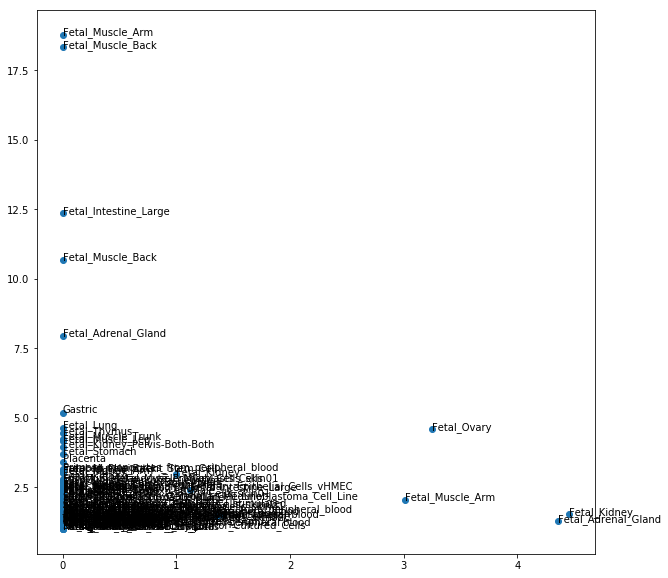

In [9]:
val_pearson = [i[0] for i in score_list_pearson]
val_spearman = [i[0] for i in score_list_spearman]
val_rand_pearson = [i[0] for i in rand_score_list_pearson]
val_rand_spearman = [i[0] for i in rand_score_list_spearman]

x = rna_vec_one
y = dna_vec_one

# label rna matrix columns as just tissue
rna_tiss_labels = []
for i in rna_col_label:
    items = i.split('.')
    rna_tiss_labels.append(items[1])
    '''
plt.figure(figsize=(10,10))
plt.scatter(x,y,label=rna_tiss_labels)
plt.title('1 rna counts and 1 dnase counts across cell types')
plt.xlabel('rna counts')
plt.ylabel('dnase counts')
plt.show()
'''
#plt.subplots()
plt.figure(figsize=(20,15))
plt.figure(figsize=(10,10))
plt.scatter(x,y)
for i, txt in enumerate(rna_tiss_labels):
    plt.annotate(txt, (x[i],y[i]))
plt.show()

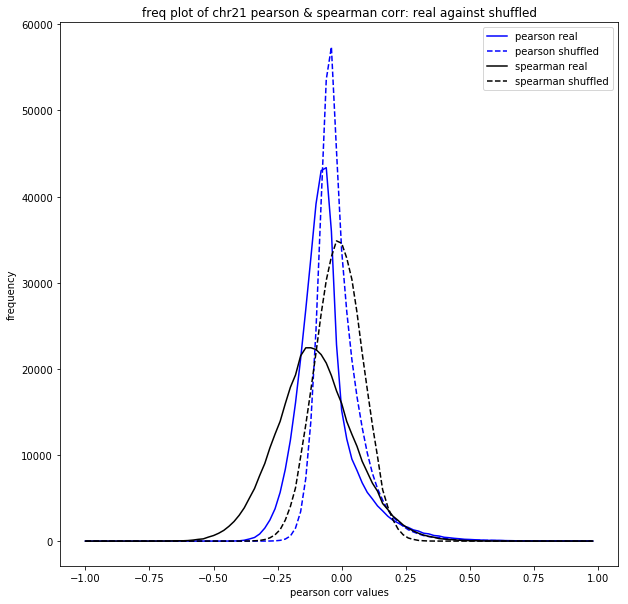

In [10]:
freq_pearson = []
freq_rand_pearson = []
freq_spearman = []
freq_rand_spearman = []
tick_marks = np.linspace(-1, 1, 101)

left_tick = -1
right_tick = -0.98
for frame in np.arange(100):
    freq_pearson.append(sum(((i > left_tick) & (i < right_tick))for i in val_pearson))
    freq_rand_pearson.append(sum(((i > left_tick) & (i < right_tick))for i in val_rand_pearson))
    freq_spearman.append(sum(((i > left_tick) & (i < right_tick))for i in val_spearman))
    freq_rand_spearman.append(sum(((i > left_tick) & (i < right_tick))for i in val_rand_spearman))

    left_tick += 0.02
    right_tick += 0.02

x = tick_marks[0:100]
y1 = freq_pearson
y2 = freq_rand_pearson
y3 = freq_spearman
y4 = freq_rand_spearman

plt.figure(figsize=(10, 10))
plt.plot(x,y1,'b',label='pearson real')
plt.plot(x,y2,'--b',label='pearson shuffled')
plt.plot(x,y3,'k',label='spearman real')
plt.plot(x,y4,'--k',label='spearman shuffled')
plt.legend(loc='upper right')
plt.title('freq plot of chr21 pearson & spearman corr: real against shuffled')
plt.xlabel('pearson corr values')
plt.ylabel('frequency')
plt.show()

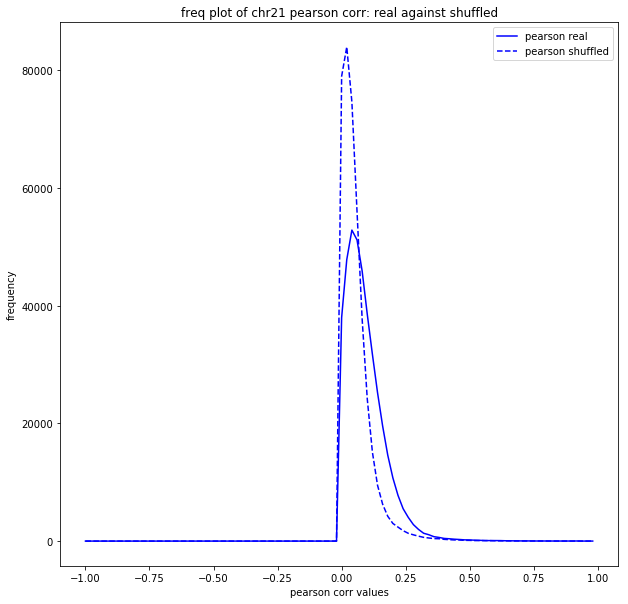

In [11]:
# absolute value of counts
freq_pearson = []
freq_rand_pearson = []
tick_marks = np.linspace(-1, 1, 101)

val_pearson_abs = [abs(number) for number in val_pearson]
val_rand_pearson_abs = [abs(number) for number in val_rand_pearson]

left_tick = -1
right_tick = -0.98
for frame in np.arange(100):
    freq_pearson.append(sum(((i > left_tick) & (i < right_tick))for i in val_pearson_abs))
    freq_rand_pearson.append(sum(((i > left_tick) & (i < right_tick))for i in val_rand_pearson_abs))

    left_tick += 0.02
    right_tick += 0.02

x = tick_marks[0:100]
y1 = freq_pearson
y2 = freq_rand_pearson

plt.figure(figsize=(10, 10))
plt.plot(x,y1,'b',label='pearson real')
plt.plot(x,y2,'--b',label='pearson shuffled')
plt.legend(loc='upper right')
plt.title('freq plot of chr21 pearson corr: real against shuffled')
plt.xlabel('pearson corr values')
plt.ylabel('frequency')
plt.show()

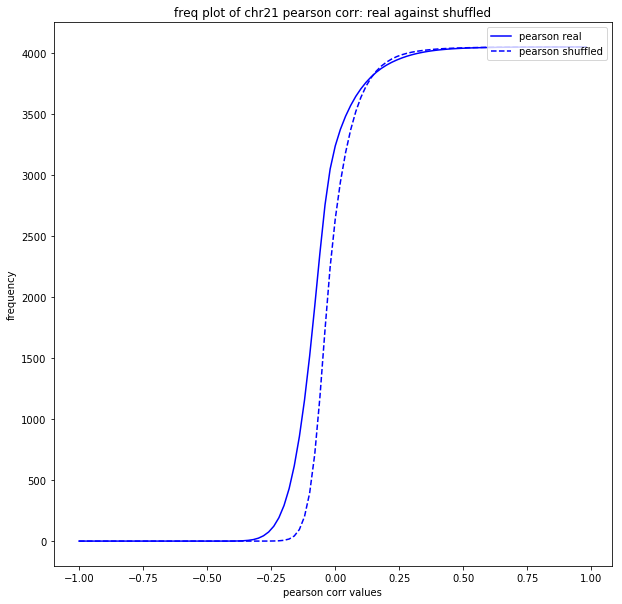

In [12]:
# now have area under curve as y axis
from scipy.integrate import simps
from numpy import trapz

freq_pearson = []
freq_rand_pearson = []
auc_pearson = []
auc_rand_pearson = []
tick_marks = np.linspace(-1, 1, 101)


left_tick = -1
right_tick = -0.98
for frame in np.arange(100):
    freq_pearson.append(sum(((i > left_tick) & (i < right_tick))for i in val_pearson))
    auc_pearson.append(trapz(freq_pearson, dx=0.01))
    freq_rand_pearson.append(sum(((i > left_tick) & (i < right_tick))for i in val_rand_pearson))
    auc_rand_pearson.append(trapz(freq_rand_pearson, dx=0.01))

    left_tick += 0.02
    right_tick += 0.02

x = tick_marks[0:100]
y1 = auc_pearson
y2 = auc_rand_pearson

plt.figure(figsize=(10, 10))
plt.plot(x,y1,'b',label='pearson real')
plt.plot(x,y2,'--b',label='pearson shuffled')
plt.legend(loc='upper right')
plt.title('freq plot of chr21 pearson corr: real against shuffled')
plt.xlabel('pearson corr values')
plt.ylabel('frequency')
plt.show()

In [13]:
'''
def main():
   parser = argparse.ArgumentParser(description='computes pearson and spearman correlation of rna and dnase counts across different samples')
   parser.add_argument('--rna_matrix_file',help='File tab delimited with rows being rna counts, columns being cell types')
   parser.add_argument('--dnase_matrix_file',help='File tab delimited with rows being dnase peaks, columns being cell types')  

   parser.add_argument('--method')

   args = parser.parse_args()

   print args

   if args.method=='correlation':
       run_correlation_method()

main()
'''

"\ndef main():\n   parser = argparse.ArgumentParser(description='computes pearson and spearman correlation of rna and dnase counts across different samples')\n   parser.add_argument('--rna_matrix_file',help='File tab delimited with rows being rna counts, columns being cell types')\n   parser.add_argument('--dnase_matrix_file',help='File tab delimited with rows being dnase peaks, columns being cell types')  \n\n   parser.add_argument('--method')\n\n   args = parser.parse_args()\n\n   print args\n\n   if args.method=='correlation':\n       run_correlation_method()\n\nmain()\n"